# <center>Final Project - Traffic Signs Recognition</center> #
####  106061224 林姮汝
***

## Description

In the world of Artificial Intelligence and advancement in technologies, autonomous vehicles and self-driving cars is a critical topic. To achieve level 5 autonomous (full automation), in which human are just passengers and can fully depend on the car, it is necessary for vehicles to understand and follow all traffic rules. So, for achieving accuracy in this technology, the vehicles should be able to interpret traffic signs and make decisions accordingly.

In this project, I’ll apply Machine Learning and Deep Learning algorithms that can classify traffic signs on the image into different categories. With these models, we are able to read and understand traffic signs which is a very important task for autonomous vehicles.

## Overall Implementation

Public dataset available at Kaggle: **`German Traffic Sign Recognition Benchmark`**

There are **`more than 50000 images`** and **`43 classes`** in total. The dataset has already been splitted into train and test set. To evaluate the performance of the model, I’ll extract part of the training data as validation set, and then feed the testing data into the model after validation.

In the following, I implement **`KNN`**, **`3-layer NN`**, and **`CNN`** and investigate their performance.<br>
(I'll illustrate the implementation of each model in detail in the corresponding sections.)

Lastly, a **`GUI (Graphical User Interface)`** is built to visualize the traffic signs classifier.

## EDA

The training set includes `39209` images while the test set includes `12630` images and the whole dataset was categorized into `43` classes. Since the input data are images, models in this project are all trained on `GPU`.

Before feeding data into models, I do some preprocessing as follows on the dataset.
1. Convert to grayscale
    - Colors aren't that important in this project.
    - RGB &rightarrow; Gray; 3 chaanels &rightarrow; 1 channel
    - Reduce dimension and computation complexity to speed up the training process.
2. Divide pixels by 255
    - Easier for the neural network to find a local or a global minimum.
    - Model converges faster.
3. Resize images to (33,33)
    - According to the width and height provided in the .csv file, I pick intermediate values so that the images won't get distorted too much.

In [3]:
!python --version

Python 3.6.12 :: Anaconda, Inc.


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization

%matplotlib inline

print(tf.__version__)

2.5.0-dev20210101


In [5]:
print(tf.test.is_built_with_cuda())
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
print("Num GPUs Available:", len(physical_devices))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1


In [5]:
Meta = pd.read_csv("./dataset/Meta.csv")
Meta.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [7]:
Meta.shape

(43, 5)

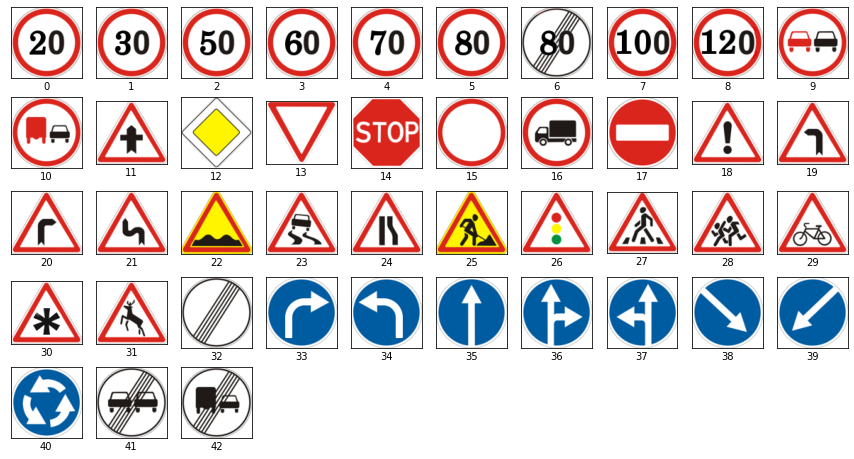

In [8]:
dir = "./dataset"
plt.figure(figsize=(15, 8))

for i in range(43):
    plt.subplot(5, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    path = dir + "/Meta/{}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

In [9]:
train = pd.read_csv("./dataset/Train.csv")
train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [10]:
train.shape

(39209, 8)

In [11]:
test = pd.read_csv("./dataset/Test.csv")
test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [12]:
test.shape

(12630, 8)

In [6]:
def preprocess(dtype):
    data = []
    labels = []
    classes = 43
    cur_path = "./dataset"
    
    if dtype == "Train":
        for i in range(classes):
            path = os.path.join(cur_path, dtype, str(i))
            images = os.listdir(path)

            for image in images:
                try:
                    img = cv2.imread(path + "/" + image)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = img/255
                    img = cv2.resize(img, (33,33))
                    data.append(img)
                    labels.append(i)
                except:
                    print("Error loading images!")
    
    elif dtype == "Test":
        test = pd.read_csv(cur_path + "/Test.csv")
        images = test["Path"].values
        labels = test["ClassId"].values
        
        for image in images:
            try:
                img = cv2.imread(cur_path + "/" + image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img/255
                img = cv2.resize(img, (33,33))
                data.append(img)
            except:
                print("Error loading images!")        

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

## Load Data

Input shape for each model:
- KNN<br>
    (n_samples, n_features)
<br><br>
- 3-Layer NN<br>
    (n_samples, n_features)
<br><br>   
- CNN<br>
    (n_samples, height, width, channels)

In [7]:
data, labels = preprocess("Train")
test_data, test_labels = preprocess("Test")

In [8]:
# training set
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)

KNN_train = data.reshape(data.shape[0], -1)
KNN_labels = labels

NN3_train = data.reshape(data.shape[0], -1)
NN3_labels = labels

CNN_train = data
CNN_labels = labels

print("KNN_train.shape: {}".format(KNN_train.shape))
print("CNN_train.shape: {}".format(CNN_train.shape))
print("train_labels.shape: {}".format(labels.shape))

# testset
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

X_test_k = test_data.reshape(test_data.shape[0], -1)
y_test_k = test_labels

X_test_3 = test_data.reshape(test_data.shape[0], -1)
y_test_3 = test_labels

X_test = test_data
y_test = test_labels

print("\n")
print("KNN_test.shape: {}".format(X_test_k.shape))
print("CNN_test.shape: {}".format(X_test.shape))
print("test_labels.shape: {}".format(test_labels.shape))

KNN_train.shape: (39209, 1089)
CNN_train.shape: (39209, 33, 33, 1)
train_labels.shape: (39209,)


KNN_test.shape: (12630, 1089)
CNN_test.shape: (12630, 33, 33, 1)
test_labels.shape: (12630,)


In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report

## KNN

- First, since I don't know under which k the model will have the best or better performance, so I do `4-cross validation` under different k from 2 to 5.<br>
- I calculate the mean of 4 cross-validation scores for each k, and find out the score when `k=2` is the best.<br> 
- Then, retrain KNN with k equals to 2 and feed in the testset to do prediction after that.<br>
- Lastly, refer to the classification report to investigate model performance.<br>
  I choose `macro average of F1-score` as the evaluation metric.<br>

  **Why F1_macro?**
    - Due to the class imbalance in this dataset, we cannot use Accuracy as the evaluation metric.
    - F1-score is a combination of Precision and Recall.
    - Macro-average method:<br>
        All classes are given the same weight. Directly sum up the F1-score of different classes and calculate the average.This method weighs each class equally. *(The result will be affected by the classes with smaller samples, and I'm fine with suffering a small loss in predicting classes with larger samples.)*
    - To prevent model from being affected by the classes with larger number of samples and leading to excessively idealized performance, F1_macro is a good choice.
    
The model reaches a `F1_macro score` of **0.31**, which is quite poor. So I'm going to build a basic DNN next.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
%%time

avg_score = []
# for k in range(2,10):
for k in range(2,6):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    score = cross_val_score(knn, KNN_train, KNN_labels, cv=4, n_jobs=2, scoring='f1_macro', verbose=1)
    avg_score.append(score.mean())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 16.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 16.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 15.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 18.2min finished


Wall time: 1h 6min 30s


Best Score: 0.270 when n_neighbors=2


Text(0, 0.5, 'f1_macro')

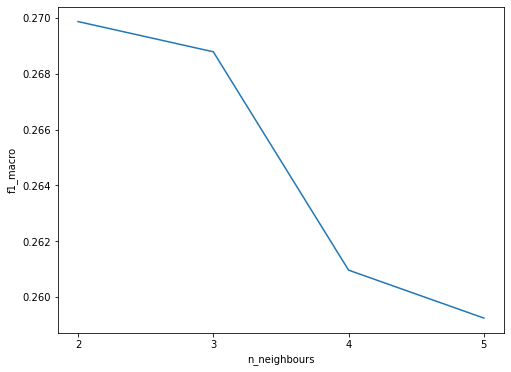

In [11]:
print("Best Score: {:.3f} when n_neighbors={:d}".format(max(avg_score), 2+np.argmax(avg_score)))
plt.figure(figsize=(8,6))
plt.plot(range(2,6), avg_score)
plt.xticks(np.arange(2, 6, 1))
plt.xlabel("n_neighbours")
plt.ylabel("f1_macro")

In [12]:
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=2)
knn.fit(KNN_train, KNN_labels)

KNeighborsClassifier(n_jobs=2, n_neighbors=2)

In [13]:
y_pred_k = knn.predict(X_test_k)

target_names = ["Class {}".format(i) for i in range(43)]
print(classification_report(y_test_k, y_pred_k, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.17      0.33      0.22        60
     Class 1       0.27      0.38      0.32       720
     Class 2       0.22      0.29      0.25       750
     Class 3       0.10      0.17      0.13       450
     Class 4       0.26      0.36      0.30       660
     Class 5       0.18      0.33      0.23       630
     Class 6       0.58      0.45      0.50       150
     Class 7       0.21      0.34      0.26       450
     Class 8       0.26      0.28      0.27       450
     Class 9       0.48      0.27      0.34       480
    Class 10       0.51      0.56      0.53       660
    Class 11       0.50      0.39      0.44       420
    Class 12       0.60      0.47      0.52       690
    Class 13       0.77      0.83      0.80       720
    Class 14       0.70      0.22      0.34       270
    Class 15       0.17      0.15      0.16       210
    Class 16       0.65      0.69      0.67       150
    Class 17       0.88    

## 3-Layer NN

I extract 1/4 of the training set as validation set.<br>
**Why training set : validation set = 3 : 1 ?**<br>
&rightarrow; I first tried 7 : 3; however, a proportion of 3 : 1 results in a better performance.

**Model:**
- Structure
[3-Layer NN](https://imgur.com/4HoxkeU)
<!-- <blockquote class="imgur-embed-pub" lang="en" data-id="4HoxkeU"><a href="https://imgur.com/4HoxkeU">View post on imgur.com</a></blockquote><script async src="//s.imgur.com/min/embed.js" charset="utf-8"></script> -->
<br>

- optimizer=`Adam`, loss=`sparse_categorical_crossentropy`
    - `Adam`: <br>
        - The most commonly used optimizer.
        - An extension to stochastic gradient descent. <br>
          It retains `Momentum's` gradient speed adjustment for the direction of the past gradient and `AdaGrad's` learning rate adjustment for the square value of the past gradient. Specifically, this algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters **beta1** and **beta2** control the decay rates of these moving averages. *(`Momentum` and `AdaGrad` are two other optimizers.)* <br>
          It has several **hyperparameters**: (the values listed are the defaults in Keras)<br>
            - **learning_rate=0.001**,
            - **beta_1=0.9**,
            - **beta_2=0.999**,
            - **epsilon=1e-07** <br>
    - `sparse_categorical_crossentropy`: <br>
        This crossentropy loss function is for two or more label classes in which the labels are expected to be integers.<br>
    - I thus choose `Adam` as the optimizer since it realizes the benefits of both AdaGrad and Momentum and achieves good results fast. As for `sparse_categorical_crossentropy`, this loss function matches the condition of our dataset so it should be the suitable choice.<br><br>

- `(batch size, epochs) = (128, 10)`<br>
    - I mainly focus on the comparison of different models, so I didn’t spend too much time trying different (batch size, epochs).
    - To speed up training process and within the capacity of GPU, I first set the batch size to 64. At last, my model performs better with **128** `batch size`, and after **10** `epochs` the accuracy was stable.
    
The model reaches a `F1_macro score` of **0.76**, which is better than the previous one but still room for improvement.

In [18]:
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(NN3_train, NN3_labels, test_size=0.25, random_state=1, stratify=NN3_labels)
X_train_3.shape[1:]

(1089,)

In [19]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=X_train_3.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               279040    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 43)                2795      
Total params: 298,283
Trainable params: 298,283
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [21]:
%%time
hist = model.fit(X_train_3, y_train_3, batch_size=128, epochs=10, validation_data=(X_val_3, y_val_3), verbose=1)  

Epoch 1/10
230/230 [==============================] - 8s 21ms/step - loss: 3.1760 - accuracy: 0.2081 - val_loss: 1.9922 - val_accuracy: 0.4795
Epoch 2/10
230/230 [==============================] - 3s 15ms/step - loss: 1.7480 - accuracy: 0.5541 - val_loss: 1.2740 - val_accuracy: 0.6955
Epoch 3/10
230/230 [==============================] - 3s 15ms/step - loss: 1.1827 - accuracy: 0.7014 - val_loss: 1.0417 - val_accuracy: 0.7585
Epoch 4/10
230/230 [==============================] - 4s 16ms/step - loss: 0.9075 - accuracy: 0.7771 - val_loss: 0.8129 - val_accuracy: 0.8000
Epoch 5/10
230/230 [==============================] - 9s 40ms/step - loss: 0.7614 - accuracy: 0.8190 - val_loss: 0.7481 - val_accuracy: 0.8151
Epoch 6/10
230/230 [==============================] - 3s 12ms/step - loss: 0.6413 - accuracy: 0.8509 - val_loss: 0.6782 - val_accuracy: 0.8366
Epoch 7/10
230/230 [==============================] - 3s 13ms/step - loss: 0.5987 - accuracy: 0.8529 - val_loss: 0.5880 - val_accuracy: 0.8622

In [22]:
model.save("model.h5")

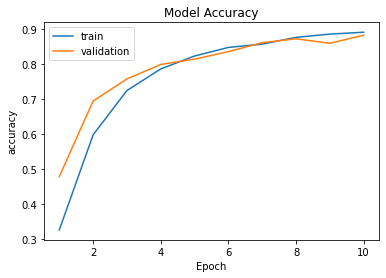

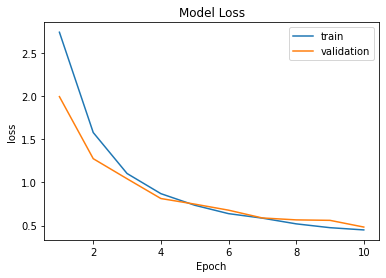

In [23]:
plt.figure(0)
plt.title('Model Accuracy')
plt.plot(range(1, 11), hist.history['accuracy'])
plt.plot(range(1, 11), hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(labels=['train','validation'])

plt.figure(1)
plt.title('Model Loss')
plt.plot(range(1, 11), hist.history['loss'])
plt.plot(range(1, 11), hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(labels=['train','validation'])

In [24]:
y_pred_soft_3 = model.predict(X_test_3)

y_pred_3 = []
for i in range(len(y_pred_soft_3)):
    y_pred_3.append(np.argmax(y_pred_soft_3[i]))
    
target_names = ["Class {}".format(i) for i in range(43)]
print(classification_report(y_test_3, y_pred_3, target_names=target_names))    

              precision    recall  f1-score   support

     Class 0       0.54      0.53      0.54        60
     Class 1       0.79      0.88      0.83       720
     Class 2       0.83      0.83      0.83       750
     Class 3       0.70      0.75      0.73       450
     Class 4       0.72      0.86      0.78       660
     Class 5       0.56      0.87      0.68       630
     Class 6       0.84      0.76      0.80       150
     Class 7       0.95      0.55      0.70       450
     Class 8       0.76      0.65      0.70       450
     Class 9       0.91      0.82      0.87       480
    Class 10       0.86      0.86      0.86       660
    Class 11       0.80      0.78      0.79       420
    Class 12       0.90      0.89      0.89       690
    Class 13       0.84      0.98      0.91       720
    Class 14       0.93      0.90      0.91       270
    Class 15       0.86      0.85      0.85       210
    Class 16       0.99      0.93      0.96       150
    Class 17       0.97    

## CNN

> Eventually, we come to CNN, which performs well on analyzing visual imagery.<br>
There are a lot of algorithms that people used for image classification before CNN became popular.<br> 
**But why CNN at last and why it works so much better?**
> - CNN can be thought of as automatic feature extractors from the image. While using an algorithm with pixel vectors, lots of spatial interaction between pixels will get lost. A CNN can solve this problem by effectively using adjacent pixel information to downsample the image first by convolution and then uses a prediction layer at the end.
> - CNN extracts the features from the images and handles the entire feature engineering part. In normal CNN architecture, beginning layers extract low-level features, and end level layers extract high-level features from the image.
> - CNN compares the image piece by piece. So CNN is better at seeing similarity than the whole image matching schemes.
> - Since CNN is a kind of deep learning neural network, transfer learning happens. It will learn more, and less error will occur.

Here, in comparison with the **3-Layer NN**:
- proportion of training set and validation set
- selection of optimizer and loss function 
- (batch size, epochs)<br>

remain the same. Let's then focus on the architecture of the **CNN** model:

**[ (CONV => RELU)*2 => POOL layers => DropOut ] * 2 => FC => Dropout => softmax**
<br>

- Layers Explanation:
    - `Pooling`: Progressively reduce the spatial dimensions of the input.
    - `Dropout`: A form of regularization that aims to prevent overfitting. Random connections are dropped to ensure that no single node in the network is responsible for activating when presented with a given pattern.
    - `Softmax`: Obtain output probabilities for multi-class.
    
The model reaches a `F1_macro score` of **0.95**, which is quite satisfying!<br>
CNN performs the best among the three models. This result is as expected and the reasons are explained at the beginning of this section.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(CNN_train, CNN_labels, test_size=0.25, random_state=1, stratify=CNN_labels)

In [12]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.3))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(43, activation='softmax'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 29, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)        

In [27]:
cnn_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [28]:
%%time
cnn_hist = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val), verbose=1)  

Epoch 1/10
230/230 [==============================] - 37s 117ms/step - loss: 2.8062 - accuracy: 0.2558 - val_loss: 0.2876 - val_accuracy: 0.9302
Epoch 2/10
230/230 [==============================] - 24s 105ms/step - loss: 0.3709 - accuracy: 0.8902 - val_loss: 0.0939 - val_accuracy: 0.9768
Epoch 3/10
230/230 [==============================] - 25s 108ms/step - loss: 0.1850 - accuracy: 0.9462 - val_loss: 0.0568 - val_accuracy: 0.9865
Epoch 4/10
230/230 [==============================] - 25s 109ms/step - loss: 0.1251 - accuracy: 0.9618 - val_loss: 0.0474 - val_accuracy: 0.9879
Epoch 5/10
230/230 [==============================] - 27s 117ms/step - loss: 0.0978 - accuracy: 0.9691 - val_loss: 0.0365 - val_accuracy: 0.9905
Epoch 6/10
230/230 [==============================] - 24s 105ms/step - loss: 0.0781 - accuracy: 0.9757 - val_loss: 0.0329 - val_accuracy: 0.9912
Epoch 7/10
230/230 [==============================] - 25s 107ms/step - loss: 0.0638 - accuracy: 0.9815 - val_loss: 0.0294 - val_ac

In [29]:
cnn_model.save("cnn_model.h5")

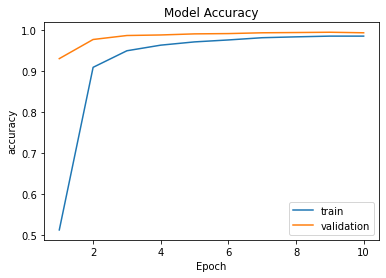

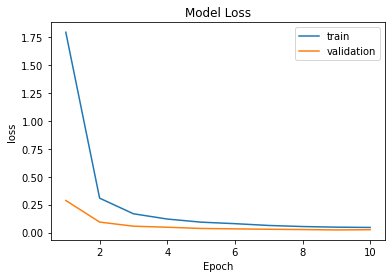

In [30]:
plt.figure(0)
plt.title('Model Accuracy')
plt.plot(range(1, 11), cnn_hist.history['accuracy'])
plt.plot(range(1, 11), cnn_hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(labels=['train','validation'])

plt.figure(1)
plt.title('Model Loss')
plt.plot(range(1, 11),cnn_hist.history['loss'])
plt.plot(range(1, 11),cnn_hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(labels=['train','validation'])

In [31]:
y_pred_soft = cnn_model.predict(X_test)

y_pred = []
for i in range(len(y_pred_soft)):
    y_pred.append(np.argmax(y_pred_soft[i]))

In [ ]:
# from mlxtend.plotting import plot_confusion_matrix

# matrix = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(matrix, figsize=(20,20), colorbar=True)

In [32]:
target_names = ["Class {}".format(i) for i in range(43)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        60
     Class 1       0.94      0.98      0.96       720
     Class 2       0.94      0.99      0.97       750
     Class 3       0.98      0.97      0.97       450
     Class 4       0.98      0.98      0.98       660
     Class 5       0.97      0.93      0.95       630
     Class 6       1.00      0.82      0.90       150
     Class 7       0.99      0.97      0.98       450
     Class 8       0.99      0.97      0.98       450
     Class 9       0.93      1.00      0.96       480
    Class 10       0.99      0.99      0.99       660
    Class 11       0.99      0.99      0.99       420
    Class 12       0.96      0.98      0.97       690
    Class 13       0.99      1.00      1.00       720
    Class 14       1.00      0.98      0.99       270
    Class 15       0.97      0.99      0.98       210
    Class 16       1.00      0.99      1.00       150
    Class 17       1.00    

## Traffic Signs Classifier GUI

After finishing model training and comparison, I build a GUI for demonstrating the CNN classifier since it has the best performance. <br>
The code is as follows and also in `Traffic Signs Classifier GUI.py`.<br>
Below is a screenshot of the GUI.
<!-- <img src="GUI.png" alt="GUI" width="500"/> -->
[GUI](https://imgur.com/3fZioYE)

In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image

import numpy as np
import cv2
import pandas as pd
#load the trained model to classify sign
import tensorflow as tf
from tensorflow.keras.models import load_model

cnn_model = load_model("./final_model/cnn_model.h5")
print("Model Loaded Sucessfully!")

#dictionary to label all traffic signs class.
classes = { 1:'Speed limit (20km/h)',
            2:'Speed limit (30km/h)', 
            3:'Speed limit (50km/h)', 
            4:'Speed limit (60km/h)', 
            5:'Speed limit (70km/h)', 
            6:'Speed limit (80km/h)', 
            7:'End of speed limit (80km/h)', 
            8:'Speed limit (100km/h)', 
            9:'Speed limit (120km/h)', 
            10:'No passing', 
            11:'No passing veh over 3.5 tons', 
            12:'Right-of-way at intersection', 
            13:'Priority road', 
            14:'Yield', 
            15:'Stop', 
            16:'No vehicles', 
            17:'Veh > 3.5 tons prohibited', 
            18:'No entry', 
            19:'General caution', 
            20:'Dangerous curve left', 
            21:'Dangerous curve right', 
            22:'Double curve', 
            23:'Bumpy road', 
            24:'Slippery road', 
            25:'Road narrows on the right', 
            26:'Road work', 
            27:'Traffic signals', 
            28:'Pedestrians', 
            29:'Children crossing', 
            30:'Bicycles crossing', 
            31:'Beware of ice/snow',
            32:'Wild animals crossing', 
            33:'End speed + passing limits', 
            34:'Turn right ahead', 
            35:'Turn left ahead', 
            36:'Ahead only', 
            37:'Go straight or right', 
            38:'Go straight or left', 
            39:'Keep right', 
            40:'Keep left', 
            41:'Roundabout mandatory', 
            42:'End of no passing', 
            43:'End no passing veh > 3.5 tons' }

#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Traffic sign classification')
top.configure(background='#CDCDCD')

label = Label(top,background='#CDCDCD', font=('arial',15,'bold')) 
sign_image = Label(top)

def true_label(file_path):
    test = pd.read_csv("./dataset/Test.csv")
    image_paths = test["Path"].values
    i = 0

    for image_path in image_paths:
        if file_path == image_path:
            break
        else:
            i = i+1
    true_class = test["ClassId"][i]
    true_sign = classes[true_class+1]

    return true_sign


def classify(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image/255
    image = cv2.resize(image, (33,33))   
    image = np.array(image)
    image = image.reshape(1, image.shape[0], image.shape[1], 1)
    pred = np.argmax(cnn_model.predict(image))
    sign = classes[pred+1]

    true_sign = true_label(file_path[58:])

    print("True Sign: {} \n Predicted Sign: {}".format(true_sign, sign))
    label.configure(foreground='#011638', text="True sign: " + true_sign + "\n" +"Predicted Sign: "+ sign) 

def show_classify_button(file_path):
    classify_b = Button(top,text="Classify Image",command=lambda: classify(file_path),padx=10,pady=5) 
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path = filedialog.askopenfilename()
        uploaded = Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im = ImageTk.PhotoImage(uploaded)

        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

upload = Button(top, text="Upload an image", command=upload_image, padx=10, pady=5)
upload.configure(background='#364156', foreground='white', font=('arial',10,'bold'))

upload.pack(side=BOTTOM, pady=50)
sign_image.pack(side=BOTTOM, expand=True)
label.pack(side=BOTTOM, expand=True)
heading = Label(top, text="Recognize Your Traffic Sign", pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD', foreground='#364156')
heading.pack()
top.mainloop()